In [1]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import os
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', ConvergenceWarning)

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True

from datetime import datetime
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

## Plot data

In [2]:
def plot_series(x, y, title, labels):

    fig = go.Figure()
    
    for i in range(len(y)):
        fig.add_trace(go.Scatter(x=x, y=y[i], name=labels[i]))

    fig.update_layout(
        title=title,
        margin=dict(l=60, r=40, t=80, b=40),
        height=600,
    )

    fig.show()

In [3]:
def plot_data(x, y, labels, title=None, xlabel="Dates", ylabel="Closing Prices ($)"):
    plt.figure()
    for i in range(len(x)):
        plt.plot(x[i], y[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()    
    plt.show()

# Read data and data preparation

In [4]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('NFLX.csv', parse_dates=['Date'], date_parser=dateparse)
print("------------------------------------------------------------------------------")
print(data.info())
print("------------------------------------------------------------------------------")
print(data.describe())
print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874 entries, 0 to 4873
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4874 non-null   datetime64[ns]
 1   Open       4874 non-null   float64       
 2   High       4874 non-null   float64       
 3   Low        4874 non-null   float64       
 4   Close      4874 non-null   float64       
 5   Adj Close  4874 non-null   float64       
 6   Volume     4874 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 266.7 KB
None
------------------------------------------------------------------------------
              Open         High          Low        Close    Adj Close  \
count  4874.000000  4874.000000  4874.000000  4874.000000  4874.000000   
mean    104.644811   106.243736   103.006660   104.686524   104.686524   
std     155.886

In [5]:
data = data.drop(columns=["Open", "Low", "High", "Adj Close", "Volume"])
display(data)

,Date,Close
0,2002-05-23,1.196429
1,2002-05-24,1.210000
2,2002-05-28,1.157143
3,2002-05-29,1.103571
4,2002-05-30,1.071429
...,...,...
4869,2021-09-24,592.390015
4870,2021-09-27,592.640015
4871,2021-09-28,583.849976
4872,2021-09-29,599.059998


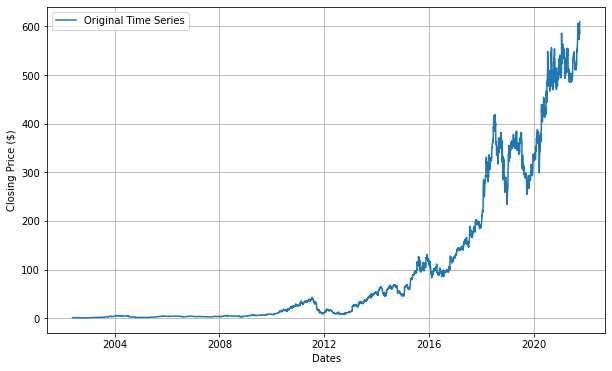

In [6]:
x, y = data["Date"], data["Close"]

plt.plot(x, y, label="Original Time Series")
plt.xlabel("Dates")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()

293


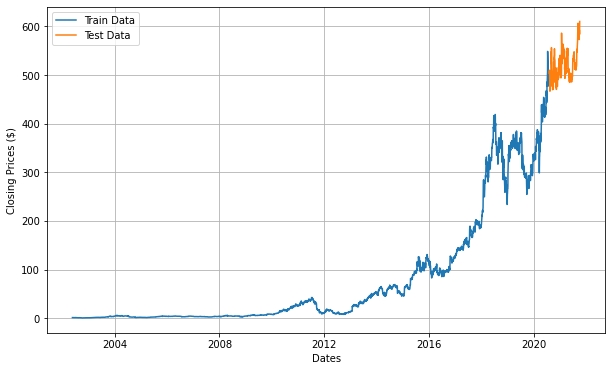

In [7]:
train_data, test_data = np.split(data, [int(.94 * len(data))])

X_train, y_train = train_data["Date"], train_data["Close"]
X_test, y_test = test_data["Date"], test_data["Close"]

print(len(X_test))

plot_data(
    [X_train, X_test],
    [y_train, y_test],
    ["Train Data", "Test Data"]
)

# Trend estimation (polinomial fit)

In [8]:
def estimation(x, y, deg, name):
    coefs = np.polyfit(x, y, deg)
    vals = np.polyval(coefs, x)
    TS = pd.Series(data=vals, index=x, name=name)
    return TS

MSE linear estimation: 8316.528
MSE quadatric estimation: 1698.974
MSE cubic estimation: 776.399


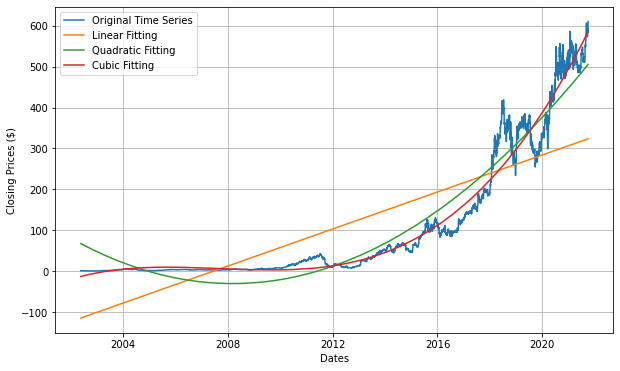

In [9]:
# Linear estimation
linTS = estimation(data.index, y, 1, 'Linear Fitting')

# Quadratic estimation
quadTS = estimation(data.index, y, 2, 'Quadratic Fitting')

# Cubic estimation
cubTS = estimation(data.index, y, 3, 'Cubic Fitting')

# 4th degree estimation
quadricTS = estimation(data.index, y, 4, '4th degree Fitting')

# 5th degree estimation
pentaTS = estimation(data.index, y, 5, '5th degree Fitting')

# 6th degree estimation
sixth_TS = estimation(data.index, y, 6, '6th degree Fitting')

# 7th degree estimation
seventh_TS = estimation(data.index, y, 7, '7th degree Fitting')

# 8th degree estimation
eighth_TS = estimation(data.index, y, 8, '8th degree Fitting')

print('MSE linear estimation:', round(mean_squared_error(y, linTS), 3))
print('MSE quadatric estimation:', round(mean_squared_error(y, quadTS), 3))
print('MSE cubic estimation:', round(mean_squared_error(y, cubTS), 3))

plot_data(
    [x for i in range(4)],
    [y, linTS, quadTS, cubTS],
    ["Original Time Series", "Linear Fitting", "Quadratic Fitting", "Cubic Fitting"]
)

# Remove trend

### Additive model

In [10]:
def remove_trend(series, estimation):
    data_no_trend = series - estimation
    return data_no_trend

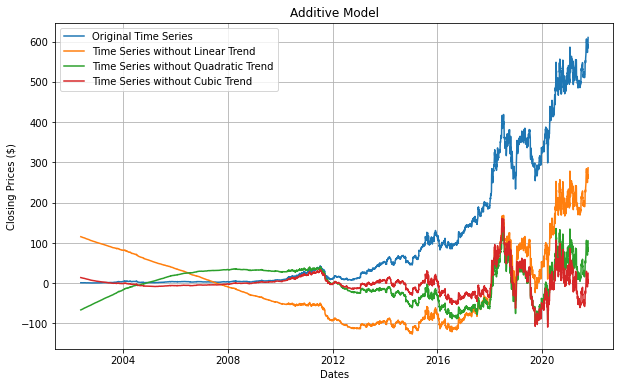

In [11]:
no_lin_trend = remove_trend(y, linTS.values)
no_quad_trend = remove_trend(y, quadTS.values)
no_cub_trend = remove_trend(y, cubTS.values)

plot_data(
    [x for i in range(4)],
    [y, no_lin_trend, no_quad_trend, no_cub_trend],
    ["Original Time Series", "Time Series without Linear Trend", "Time Series without Quadratic Trend", "Time Series without Cubic Trend"],
    "Additive Model"
)

### Multiplicative model

In [12]:
def divided_trend(data, trend):
    data_no_trend = data.values/trend.values
    
    indexes = np.where((data_no_trend > (3 * np.std(data_no_trend))) | (data_no_trend < (-3 * np.std(data_no_trend))))
    if not indexes:
        data_no_trend[indexes] = np.nan
    
    return data_no_trend

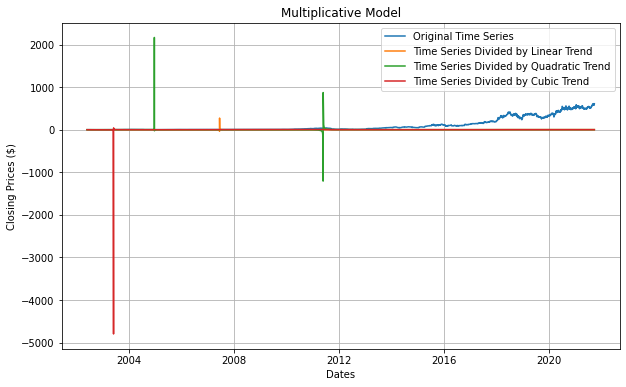

In [13]:
data_no_lin_trend = divided_trend(y, linTS)
data_no_quad_trend = divided_trend(y, quadTS)
data_no_cub_trend = divided_trend(y, cubTS)

plot_data(
    [x for i in range(4)],
    [y, data_no_lin_trend, data_no_quad_trend, data_no_cub_trend],
    ["Original Time Series", 'Time Series Divided by Linear Trend', 'Time Series Divided by Quadratic Trend', 'Time Series Divided by Cubic Trend'],
    "Multiplicative Model"
)

### Pseudo-additive (acho que é isto)

Fazer shift (por exemplo + 1000), multiplicativo e depois shift para baixo

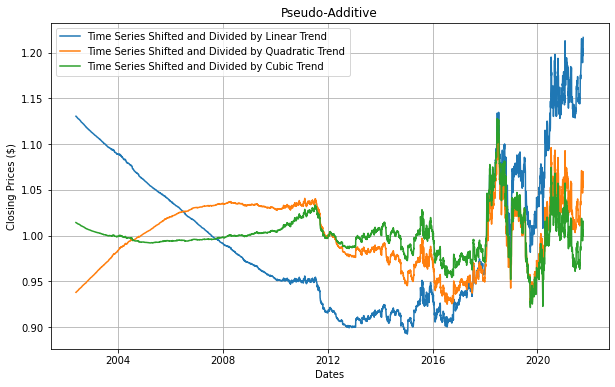

In [14]:
y_pseudo = y.copy()
y_pseudo += 1000

pseudo_data_no_lin_trend = divided_trend(y_pseudo, linTS + 1000)
pseudo_data_no_quad_trend = divided_trend(y_pseudo, quadTS + 1000)
pseudo_data_no_cub_trend = divided_trend(y_pseudo, cubTS + 1000)

'''y_pseudo -= 1000
pseudo_data_no_lin_trend -= 1000
pseudo_data_no_quad_trend -= 1000
pseudo_data_no_cub_trend -= 1000'''

plot_data(
    [x for i in range(3)],
    [pseudo_data_no_lin_trend, pseudo_data_no_quad_trend, pseudo_data_no_cub_trend],
    ['Time Series Shifted and Divided by Linear Trend', 'Time Series Shifted and Divided by Quadratic Trend', 'Time Series Shifted and Divided by Cubic Trend'],
    "Pseudo-Additive"
)

# Moving average

In [15]:
def maSmooth(TSeries, omega, data_aug=False):
    M = omega.shape[0]
    lag = int(np.floor((M - 1) / 2))
    
    if data_aug: # Para corrigir início e fim por não terem M valores para calcular MA
        TSeriesAug = pd.Series(np.concatenate((np.flip(TSeries[:lag]), TSeries, np.flip(TSeries[-lag:]))))       
    else:
        TSeriesAug = TSeries
        
    nf = range(lag, TSeriesAug.size - lag)
    xf = np.zeros(TSeriesAug.size - 2 * (lag)).astype('float')
    
    sum_omega_k = 1 / float(sum(omega))
    for n in nf:
        xf[n - lag] = sum_omega_k * np.sum(np.multiply(TSeriesAug[n - lag:n + lag + 1], omega))
    xf = pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size - lag], name="Smoothed TS with M=" + str(M))
    
    return xf

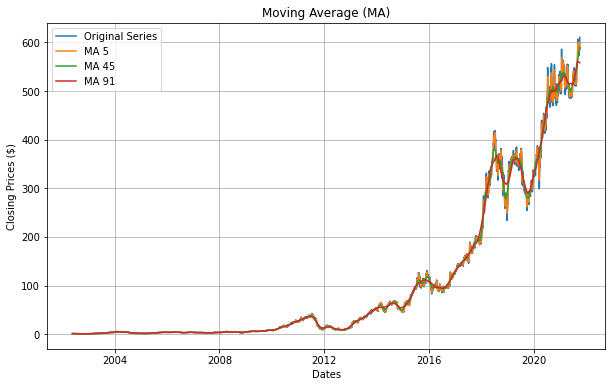

Wall time: 4.22 s


In [16]:
%%time

M = 5
omega = np.ones(M) * (1 / float(M))
smooth5 = maSmooth(y, omega, data_aug=True)

M = 45
omega = np.ones(M) * (1 / float(M))
smooth45 = maSmooth(y, omega, data_aug=True)

M = 91
omega = np.ones(M) * (1 / float(M))
smooth91 = maSmooth(y, omega, data_aug=True)

plot_data(
    [x for i in range(4)], 
    [y, smooth5, smooth45, smooth91], 
    ['Original Series', 'MA 5', 'MA 45', 'MA 91'],
    "Moving Average (MA)"
)

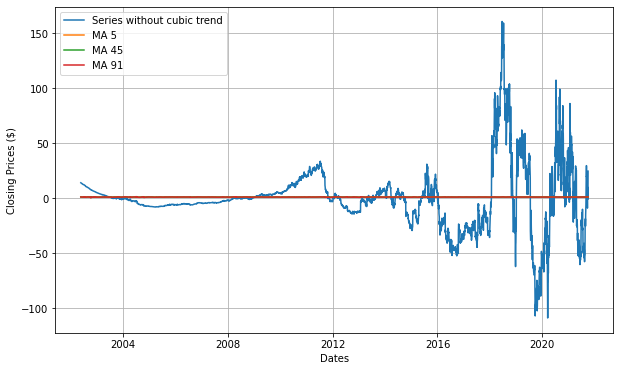

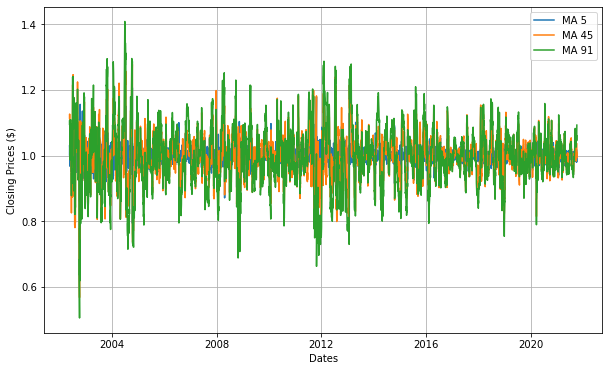

In [17]:
trend_ma5 = divided_trend(y, smooth5)
trend_ma45 = divided_trend(y, smooth45)
trend_ma91 = divided_trend(y, smooth91)

plot_data(
    [x for i in range(4)],
    [no_cub_trend, trend_ma5, trend_ma45, trend_ma91],
    ['Series without cubic trend', 'MA 5', 'MA 45', 'MA 91']
)

plot_data(
    [x for i in range(3)],
    [trend_ma5, trend_ma45, trend_ma91],
    ['MA 5', 'MA 45', 'MA 91']
)

# LOESS/LOWESS

In [18]:
def xWeights(x, xi, span):
    return (1 - abs((x - xi) / float(span)) ** 3) ** 3


def yWeights(ri, MAD):
    if np.abs(ri) < 6 * MAD:
        return (1 - ((ri / (6 * MAD)) ** 2)) ** 2
    return 0


def loessPass(TSeries, TSeriesE=pd.Series(np.array([])), span=5, timePass=True):
    lag = int((span - 1) / 2)
    xf = np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k <= lag:  # No inicio
            win = TSeries[0:span]
            if not timePass:
                winE = TSeriesE[0:span]
            xvs = np.array(range(span))
        elif k > TSeries.size - lag:  # No fim
            win = TSeries[TSeries.size - span:TSeries.size]
            if not timePass:
                winE = TSeriesE[TSeriesE.size - span:TSeriesE.size]
            xvs = np.array(range(TSeries.size - span, TSeries.size))
        else:  # No meio
            win = TSeries[k - lag - 1:k + lag]
            if not timePass:
                winE = TSeriesE[k - lag - 1:k + lag]
            xvs = np.array(range(k - lag, k + lag + 1))

        ws = np.zeros(span).astype('float')
            
        if not timePass:
            res = np.array(win - winE)
            MAD = np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw] = xWeights(k, xvs[xw], np.max((np.abs(k - xvs[0]), np.abs(k - xvs[-1]))))
            else:
                ws[xw] = yWeights(res[xw], MAD)
        exog = sm.add_constant(xvs)
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k] = res_wls.params[1] * k + res_wls.params[0]
    return xf

def lowess(TSeries, span=5):
    xf = loessPass(TSeries, span=span, timePass=True)
    xf = loessPass(TSeries, TSeriesE=pd.Series(data=xf, index=TSeries.index), span=span, timePass=False)
    xf = pd.Series(data=xf, index=TSeries.index, name=f"Smoothed TS with M={span}")
    return xf

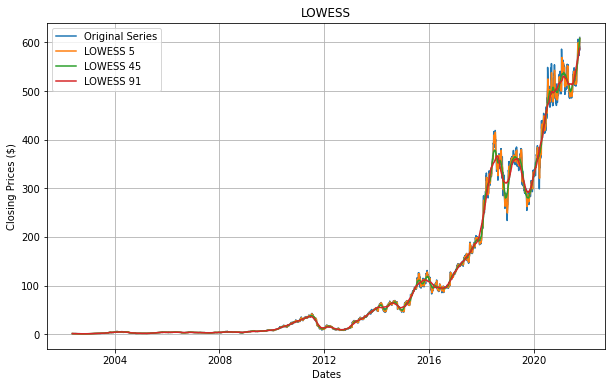

Wall time: 44.9 s


In [19]:
%%time

span = 5
lowess5 = lowess(y, span)

span = 45
lowess45 = lowess(y, span)

span = 91
lowess91 = lowess(y, span)


plot_data(
    [x for i in range(4)], 
    [y, lowess5, lowess45, lowess91],
    ['Original Series', 'LOWESS 5', 'LOWESS 45', 'LOWESS 91'],
    "LOWESS"
)

1936   2010-02-01
1937   2010-02-02
1938   2010-02-03
1939   2010-02-04
1940   2010-02-05
          ...    
1994   2010-04-26
1995   2010-04-27
1996   2010-04-28
1997   2010-04-29
1998   2010-04-30
Name: Date, Length: 63, dtype: datetime64[ns]


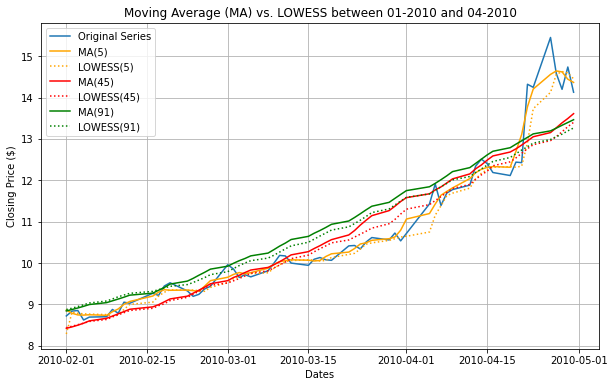

In [20]:
mini = 1936
maxi = 1999
print(x[mini:maxi])

plt.figure()
plt.plot(x[mini:maxi], y[mini:maxi], label="Original Series")
plt.plot(x[mini:maxi], smooth5[mini:maxi], label="MA(5)", c='orange')
plt.plot(x[mini:maxi], lowess5[mini:maxi], label="LOWESS(5)", c='orange', ls=':')
plt.plot(x[mini:maxi], smooth45[mini:maxi], label="MA(45)", c='red')
plt.plot(x[mini:maxi], lowess45[mini:maxi], label="LOWESS(45)", c='red', ls=':')
plt.plot(x[mini:maxi], smooth91[mini:maxi], label="MA(91)", c='green')
plt.plot(x[mini:maxi], lowess91[mini:maxi], label="LOWESS(91)", c='green', ls=':')
plt.title("Moving Average (MA) vs. LOWESS between 01-2010 and 04-2010")
plt.xlabel("Dates")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()

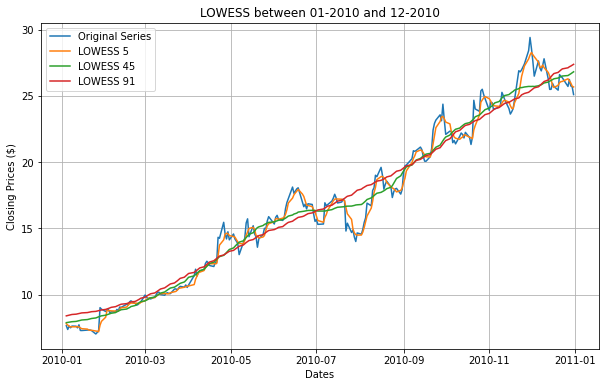

In [21]:
mini = 1917
maxi = 2169

plot_data(
    [x[mini:maxi] for i in range(4)], 
    [y[mini:maxi], lowess5[mini:maxi], lowess45[mini:maxi], lowess91[mini:maxi]],
    ['Original Series', 'LOWESS 5', 'LOWESS 45', 'LOWESS 91'],
    "LOWESS between 01-2010 and 12-2010"
)

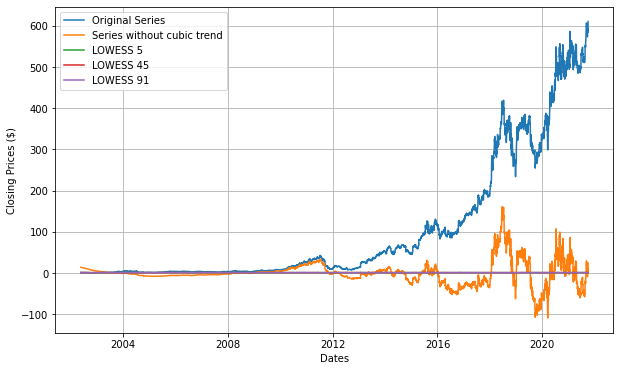

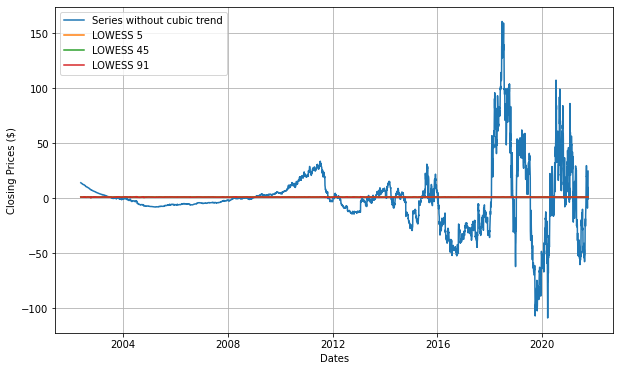

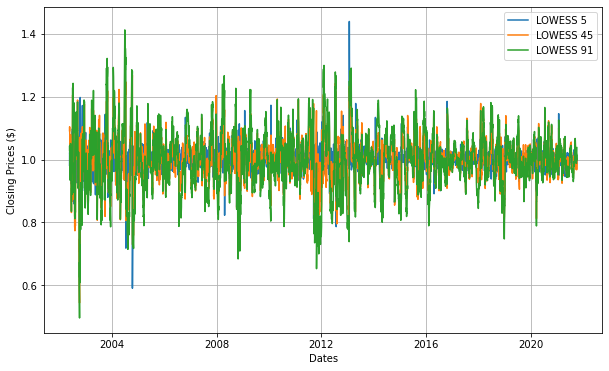

In [22]:
trend_lowess5 = divided_trend(y, lowess5)
trend_lowess45 = divided_trend(y, lowess45)
trend_lowess91 = divided_trend(y, lowess91)

plot_data(
    [x for i in range(5)], 
    [y, no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess91],
    ['Original Series', 'Series without cubic trend', 'LOWESS 5', 'LOWESS 45', 'LOWESS 91']
)

plot_data(
    [x for i in range(4)], 
    [no_cub_trend, trend_lowess5, trend_lowess45, trend_lowess91],
    ['Series without cubic trend', 'LOWESS 5', 'LOWESS 45', 'LOWESS 91']
)

plot_data(
    [x for i in range(3)], 
    [trend_lowess5, trend_lowess45, trend_lowess91],
    ['LOWESS 5', 'LOWESS 45', 'LOWESS 91']
)

# Trend with diff

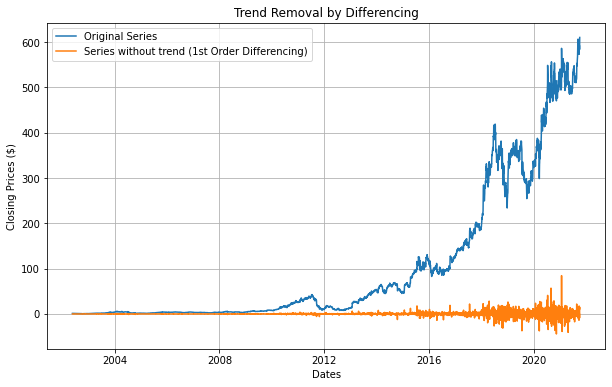

In [23]:
'''fig, axs = plt.subplots(3, figsize=(12, 7))
fig.tight_layout()

y.plot(ax=axs[0], label="Original Time Series", legend=True, color='r')
axs[0].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[0].set_xlabel('Dates', fontdict={'fontsize':8})

d1psT = y.diff()
d1psT.name = "Netflix Stock Price (1st-order Differencing) - No trend"
d1psT.plot(ax=axs[1], legend=True, color='k')
axs[1].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[1].set_xlabel('Dates', fontdict={'fontsize':8})

d1psTS = d1psT.diff(364)
d1psTS.name = "Netflix Stock Price (2nd-order Differencing) - No trend & No Seas"
d1psTS.plot(ax=axs[2], legend=True, color='k')
axs[2].set_ylabel('Closing Prices ($)', fontdict={'fontsize':8})
axs[2].set_xlabel('Dates', fontdict={'fontsize':8})'''
plt.figure()
plt.plot(x, y, label='Original Series')
plt.plot(x, y.diff(), label='Series without trend (1st Order Differencing)')
plt.legend()
plt.xlabel("Dates")
plt.ylabel("Closing Prices ($)")
plt.title("Trend Removal by Differencing")
plt.show()

# Separate trend and seasonality

<Figure size 720x432 with 0 Axes>

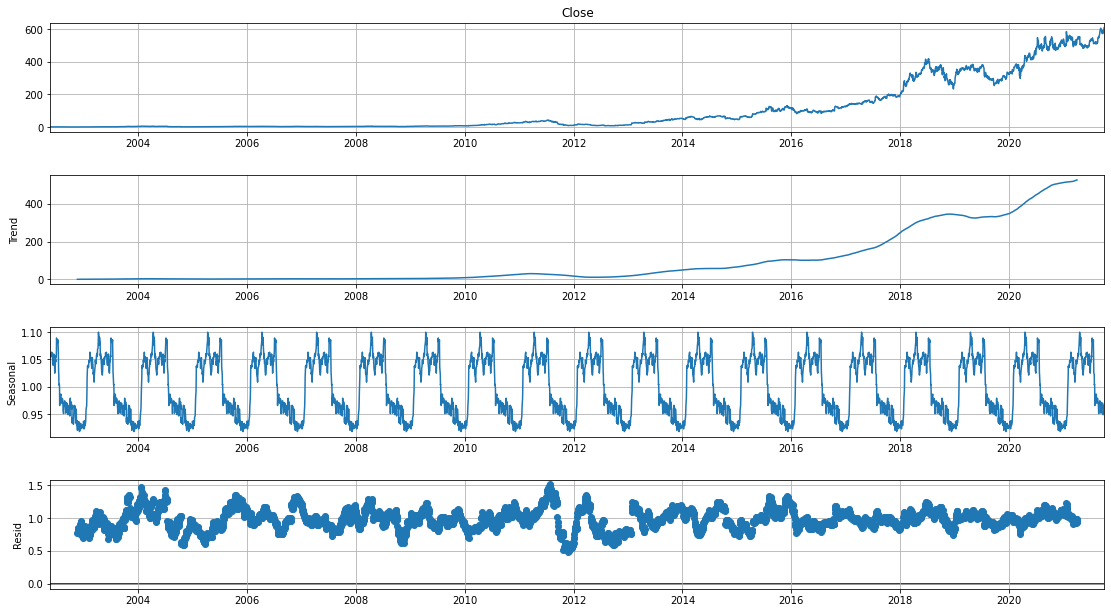

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

values = y
values.index = x

result = seasonal_decompose(values, model='multiplicative', period=252)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# ADF test (Dicky Fuller)

In [25]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(time_series, alpha=0.05):
    res = adfuller(time_series.dropna())
    
    print('ADF Statistic: %f' % res[0])
    print('p-value: %f' % res[1])
    print('Critical Values:')
    
    for key, value in res[4].items():
        print('\t%s: %.3f' % (key, value))
    print("> This Time Series is Not Stationary") if res[1] > alpha else print("> This Time Series is Stationary")

def rolling_mean_std(timeseries, lag):
    rolmean = timeseries.rolling(lag).mean()
    rolstd = timeseries.rolling(lag).std()
    
    #Plot rolling statistics:
    plt.figure()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

ADF Statistic: 2.793546
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Not Stationary
-----------------------------
ADF Statistic: -12.296602
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Stationary
---------------------------------------------------------------------------------------


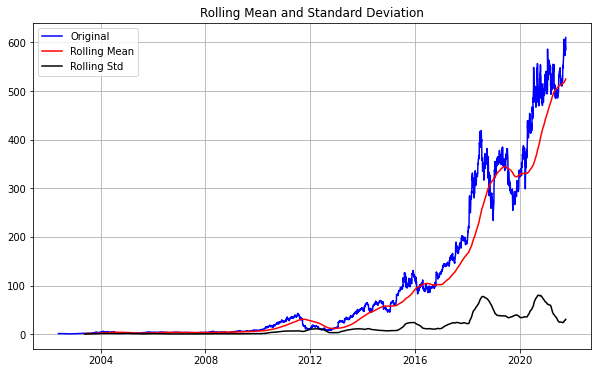

------------------------------------------------------------------------------


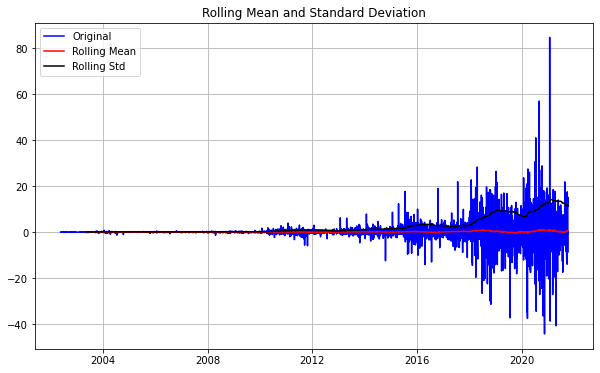

In [26]:
# If the p-value is greater than alpha, you assume that the null hypothesis is true.


# If P-Value < Alpha : This means that the NULL hypothesis can be rejected => (aka it is Stationary)
# If P-Value > Alpha : This means that the NULL hypothesis is accepted (aka failed to be rejected) => (AR(1) and NOT Stationary).

test_stationary(y)
print("-----------------------------")
test_stationary(y.diff())
print("---------------------------------------------------------------------------------------")
rolling_mean_std(y, 252)
print("------------------------------------------------------------------------------")
rolling_mean_std(y.diff(), 252)

1. Verify if the original TS is stationary. If so, we are done with d=0 and D=0


2. If the series is not stationary and has a trend apply a simple differencing operation to remove the trend. If trend is removed then d=1, if not apply d=2 (Should be enough!!)


----- #1 -----
ADF Statistic: 2.793546
p-value: 1.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Not Stationary
----- #2 -----
ADF Statistic: -12.296602
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
> This Time Series is Stationary
Since there are no regular peaks, it means that the TS does not have seasonality.


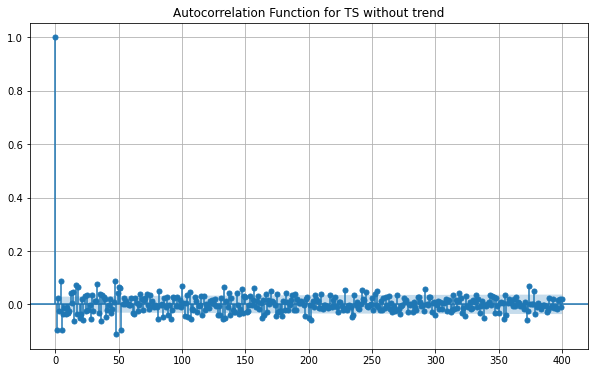

In [27]:
# 1
print("----- #1 -----")
test_stationary(y)

# 2
print("----- #2 -----")
no_trend = y.diff()
plot_acf(no_trend.dropna(), lags=400, title='Autocorrelation Function for TS without trend')
test_stationary(no_trend.dropna())

print("Since there are no regular peaks, it means that the TS does not have seasonality.")

## ARIMA testing

In [28]:
errors_aic_without_season = None
errors_bic_without_season = None
errors_mse_without_season = None

if os.path.isfile("tests\\best_params_aic_without_season.csv") and os.path.isfile("tests\\best_params_bic_without_season.csv") and os.path.isfile("tests\\best_params_mse_without_season.csv"):
    errors_aic_without_season = pd.read_csv("tests\\best_params_aic_without_season.csv")
    errors_bic_without_season = pd.read_csv("tests\\best_params_bic_without_season.csv")
    errors_mse_without_season = pd.read_csv("tests\\best_params_mse_without_season.csv")
else:
    errors_aic_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    errors_bic_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    errors_mse_without_season = pd.DataFrame(columns=["p", "d", "q", "value"])
    for p in range(10):
        for q in range(10):
            model = ARIMA(y_train, order=(p, 1, q))
            fitted = model.fit()

            errors_aic_without_season = errors_aic_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.aic}, ignore_index=True)
            errors_bic_without_season = errors_bic_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.bic}, ignore_index=True)
            errors_mse_without_season = errors_mse_without_season.append({"p": p, "d": 1, "q": q, "value": fitted.mse}, ignore_index=True)

            print(f'p={p}, d=1, q={q} / AIC: {fitted.aic}')
            print(f'p={p}, d=1, q={q} / BIC: {fitted.bic}')
            print(f'p={p}, d=1, q={q} / MSE: {fitted.mse}')
            print("--------------------------------------------")
    errors_aic_without_season.to_csv("tests\\best_params_aic_without_season.csv", index=False)
    errors_bic_without_season.to_csv("tests\\best_params_bic_without_season.csv", index=False)
    errors_mse_without_season.to_csv("tests\\best_params_mse_without_season.csv", index=False)

### Best parameters AIC

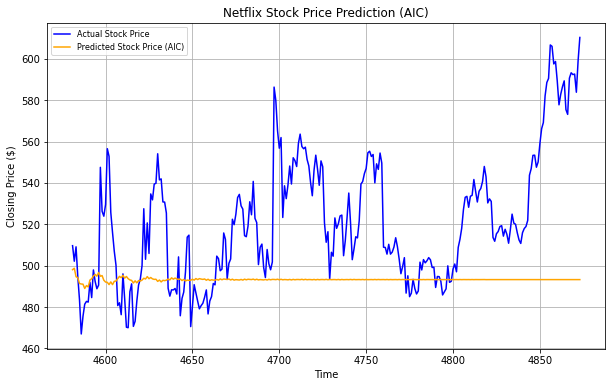

Best parameters AIC: (8.0, 1.0, 9.0)
AIC: 24724.407
MSE(y_test, pred): 1707.954


In [29]:
mini_aic = np.min(errors_aic_without_season["value"])
row_aic = errors_aic_without_season[errors_aic_without_season["value"] == mini_aic]
p_aic, d_aic, q_aic = row_aic["p"].values[0], row_aic["d"].values[0], row_aic["q"].values[0]

model = ARIMA(y_train, order=(p_aic, d_aic, q_aic))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series_aic = pd.Series(fc)
fc_series_aic.index = X_test.index

plt.figure()
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(fc_series_aic, color='orange', label='Predicted Stock Price (AIC)')

plt.title('Netflix Stock Price Prediction (AIC)')
plt.xlabel('Time')
plt.ylabel('Closing Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters AIC: ({p_aic}, {d_aic}, {q_aic})\nAIC: {round(mini_aic, 3)}')
print(f"MSE(y_test, pred): {round(mean_squared_error(y_test, fc), 3)}")

### Best parameters BIC

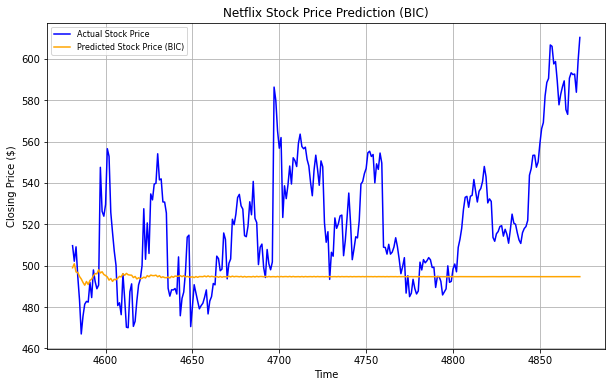

Best parameters BIC: (6.0, 1.0, 6.0)
BIC: 24814.315
MSE(y_test, pred): 1629.67


In [30]:
mini_bic = np.min(errors_bic_without_season["value"])
row_bic = errors_bic_without_season[errors_bic_without_season["value"] == mini_bic]
p_bic, d_bic, q_bic = row_bic["p"].values[0], row_bic["d"].values[0], row_bic["q"].values[0]

model = ARIMA(y_train, order=(p_bic, d_bic, q_bic))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series_bic = pd.Series(fc)
fc_series_bic.index = X_test.index

plt.figure()
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(fc_series_bic, color='orange', label='Predicted Stock Price (BIC)')

plt.title('Netflix Stock Price Prediction (BIC)')
plt.xlabel('Time')
plt.ylabel('Closing Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters BIC: ({p_bic}, {d_bic}, {q_bic})\nBIC: {round(mini_bic, 3)}')
print(f"MSE(y_test, pred): {round(mean_squared_error(y_test, fc), 3)}")

### Best parameters MSE

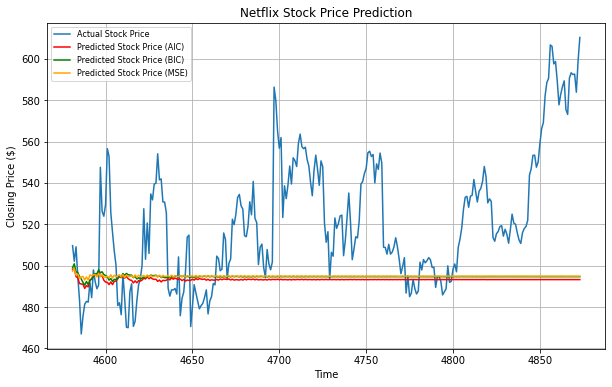

Best parameters MSE: (9.0, 1.0, 9.0)
MSE: 12.834
MSE(y_test, pred): 1618.165


In [31]:
mini_mse = np.min(errors_mse_without_season["value"])
row_mse = errors_mse_without_season[errors_mse_without_season["value"] == mini_mse]
p_mse, d_mse, q_mse = row_mse["p"].values[0], row_mse["d"].values[0], row_mse["q"].values[0]

model = ARIMA(y_train, order=(p_mse, d_mse, q_mse))
fitted = model.fit()
fc = fitted.forecast(steps=len(y_test), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc)
fc_series.index = X_test.index

plt.figure()
plt.plot(y_test, label='Actual Stock Price')
plt.plot(fc_series_aic, color='red', label='Predicted Stock Price (AIC)')
plt.plot(fc_series_bic, color='green', label='Predicted Stock Price (BIC)')
plt.plot(fc_series, color='orange', label='Predicted Stock Price (MSE)')

plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

print(f'Best parameters MSE: ({p_mse}, {d_mse}, {q_mse})\nMSE: {round(mini_mse, 3)}')
print(f"MSE(y_test, pred): {round(mean_squared_error(y_test, fc), 3)}")

Regarding the ARIMA tests to find the best parameters, we started by fixing the d value to 1 since the TS becomes stationary with differencing of 1.
After that, we tested every combination of (p, d, q) from p and q ranging from 0 to 9. We also tested using 3 different metric to evaluate the results on the training set. The best values are presented below:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-7btt">Best Values</th>
    <th class="tg-7btt">Metric Value in Train</th>
    <th class="tg-amwm">Metric Value in Test (MSE)</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-amwm">AIC</td>
    <td class="tg-c3ow">(8, 1, 9)</td>
    <td class="tg-c3ow">24724.407</td>
    <td class="tg-baqh">1707.954</td>
  </tr>
  <tr>
    <td class="tg-amwm">BIC</td>
    <td class="tg-c3ow">(6, 1, 6)</td>
    <td class="tg-c3ow">24814.315</td>
    <td class="tg-baqh">1629.670</td>
  </tr>
  <tr>
    <td class="tg-amwm">MSE</td>
    <td class="tg-c3ow">(9, 1, 9)</td>
    <td class="tg-c3ow">12.834</td>
    <td class="tg-baqh">1618.165</td>
  </tr>
</tbody>
</table>

Although we cannot compare the results in the training set, we can compare it in the the testing set. The metric that obtained the best result was the MSE with the result of 1618.165 of MSE in the testing set. From now on, we fixated the parameters of (9, 1, 9). To notice that in the plots, we can see that every prediction was bad.

## ARIMA testing with semi-fixed window (start fixed, end variable)

MSE(y_test, pred): 1640.944


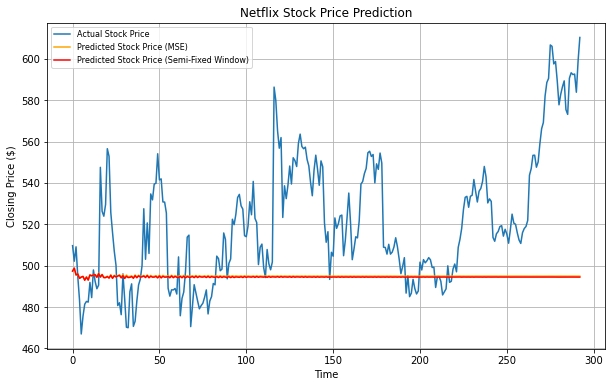

In [32]:
predictions = y_train.tolist()
y_test_copy = y_test.tolist()
xis = list(range(len(y_test_copy)))

if os.path.isfile("tests\\arima_semi-fixed.txt"):
    with open("tests\\arima_semi-fixed.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            predictions.append(float(meh[i]))
else:
    for t in range(len(y_test_copy)):
        model = ARIMA(predictions, order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = y_test_copy[t]
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        
    with open("tests\\arima_semi-fixed.txt", "w") as f_out:
        for i in predictions[len(y_train):]:
            f_out.write(str(i) + ',')
    
# evaluate forecasts
print(f"MSE(y_test, pred): {round(mean_squared_error(y_test, predictions[len(y_train):]), 3)}")

# plot forecasts against actual outcomes
plt.figure()
plt.plot(xis, y_test_copy, label="Actual Stock Price")
plt.plot(xis, fc_series, color='orange', label='Predicted Stock Price (MSE)')
plt.plot(xis, predictions[len(y_train):], color='red', label="Predicted Stock Price (Semi-Fixed Window)")
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price ($)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In this method, we predict one point at a time but we have a variable window that increases with those predictions.

If we compare this method with the best result of the task of finding the best parameters, we got a decrease of performance MSE value of 1640.944 - 1618.165 = 22.779

## ARIMA testing with variable window (1, 5, 22, 88, 252)

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 293): 145.449


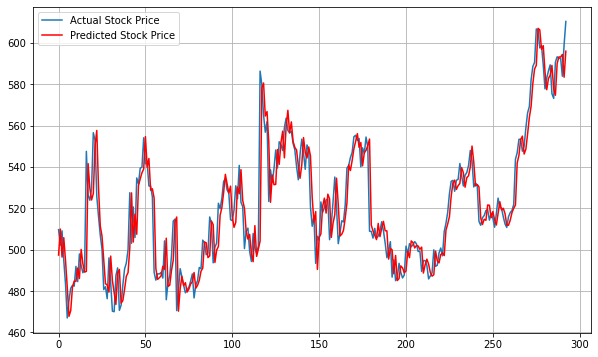

In [33]:
predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 1
forecasts_1 = []

if os.path.isfile(f"tests\\arima_variable-{window_size}.txt"):
    with open(f"tests\\arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts_1.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        forecasts_1.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"tests\\arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts_1:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts_1):
    mse = round(mean_squared_error(y_test_copy, forecasts_1[:len(y_test_copy)]), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_1)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_1[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts_1):
    mse = round(mean_squared_error(y_test_copy[:len(forecasts_1)], forecasts_1), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_1)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts_1)], label="Actual Stock Price")
    plt.plot(forecasts_1, color='red', label="Predicted Stock Price")
else:
    mse = round(mean_squared_error(y_test_copy, forecasts_1), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_1)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_1, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 295): 358.871


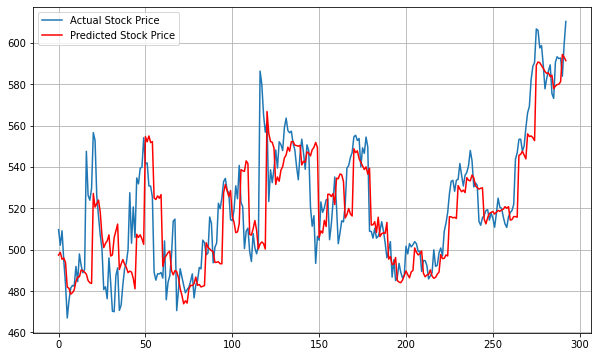

Wall time: 272 ms


In [34]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 5
forecasts_5 = []

if os.path.isfile(f"tests\\arima_variable-{window_size}.txt"):
    with open(f"tests\\arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts_5.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        forecasts_5.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"tests\\arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts_5:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts_5):
    mse = round(mean_squared_error(y_test_copy, forecasts_5[:len(y_test_copy)]), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_5)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_5[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts_5):
    mse = round(mean_squared_error(y_test_copy[:len(forecasts_5)], forecasts_5), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_5)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts)], label="Actual Stock Price")
    plt.plot(forecasts_5, color='red', label="Predicted Stock Price")
else:
    mse = round(mean_squared_error(y_test_copy, forecasts_5), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_5)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_5, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 308): 1114.158


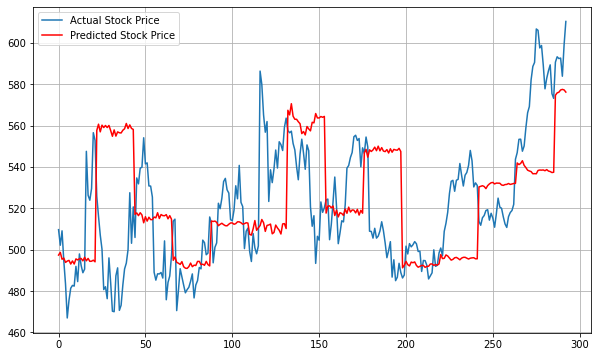

Wall time: 274 ms


In [35]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 22
forecasts_22 = []

if os.path.isfile(f"tests\\arima_variable-{window_size}.txt"):
    with open(f"tests\\arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts_22.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        forecasts_22.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"tests\\arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts_22:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts_22):
    mse = round(mean_squared_error(y_test_copy, forecasts_22[:len(y_test_copy)]), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_22)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_22[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts_22):
    mse = round(mean_squared_error(y_test_copy[:len(forecasts_22)], forecasts_22), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_22)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts_22)], label="Actual Stock Price")
    plt.plot(forecasts_22, color='red', label="Predicted Stock Price")
else:
    mse = round(mean_squared_error(y_test_copy, forecasts_22), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_22)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_22, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 352): 1072.905


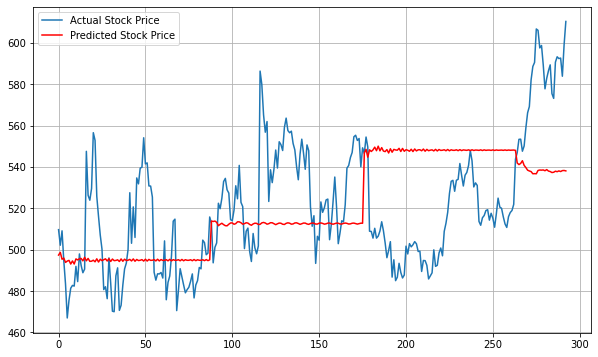

Wall time: 265 ms


In [36]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 88
forecasts_88 = []

if os.path.isfile(f"tests\\arima_variable-{window_size}.txt"):
    with open(f"tests\\arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts_88.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        forecasts_88.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"tests\\arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts_88:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts_88):
    mse = round(mean_squared_error(y_test_copy, forecasts_88[:len(y_test_copy)]), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_88)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_88[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts_88):
    mse = round(mean_squared_error(y_test_copy[:len(forecasts_88)], forecasts_88), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_88)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts_88)], label="Actual Stock Price")
    plt.plot(forecasts_88, color='red', label="Predicted Stock Price")
else:
    mse = round(mean_squared_error(y_test_copy, forecasts_88), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_88)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_88, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

Test MSE (len(y_test_copy) = 293 / len(forecasts) = 504): 1326.063


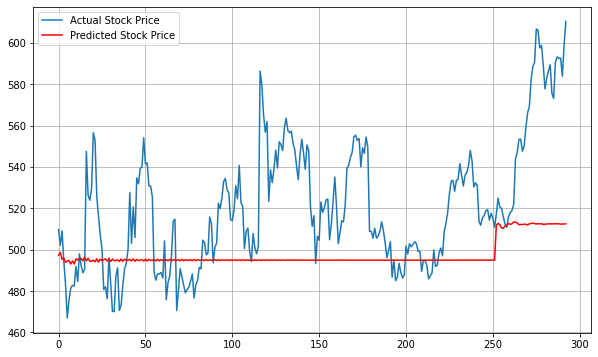

Wall time: 250 ms


In [37]:
%%time

predictions = y_train.tolist()
y_test_copy = y_test.tolist()

window_size = 252
forecasts_252 = []

if os.path.isfile(f"tests\\arima_variable-{window_size}.txt"):
    with open(f"tests\\arima_variable-{window_size}.txt", "r") as f:
        aux = f.read()
        meh = aux.split(",")
        for i in range(len(meh)):
            forecasts_252.append(float(meh[i]))
else:
    for t in range(0, len(y_test_copy), window_size):
        model = ARIMA(predictions[t:len(y_train) + t], order=(9, 1, 9))
        model_fit = model.fit()
        output = model_fit.forecast(steps=window_size)
        yhat = output
        forecasts_252.append(yhat)
        obs = y_test_copy[t:t+window_size]
        predictions += obs
        print(f'[{t + 1}] predicted={yhat}, expected={obs}')
        print("-------------")

    with open(f"tests\\arima_variable-{window_size}.txt", "w") as f:
        for i in forecasts_252:
            f.write(str(i) + ',')

plt.figure()
if len(y_test_copy) < len(forecasts_252):
    mse = round(mean_squared_error(y_test_copy, forecasts_252[:len(y_test_copy)]), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_252)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_252[:len(y_test_copy)], color='red', label="Predicted Stock Price")
elif len(y_test_copy) > len(forecasts):
    mse = round(mean_squared_error(y_test_copy[:len(forecasts_252)], forecasts_252), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_252)}): {mse}')
    plt.plot(y_test_copy[:len(forecasts_252)], label="Actual Stock Price")
    plt.plot(forecasts_252, color='red', label="Predicted Stock Price")
else:
    mse = round(mean_squared_error(y_test_copy, forecasts_252), 3)
    print(f'Test MSE (len(y_test_copy) = {len(y_test_copy)} / len(forecasts) = {len(forecasts_252)}): {mse}')
    plt.plot(y_test_copy, label="Actual Stock Price")
    plt.plot(forecasts_252, color='red', label="Predicted Stock Price")
plt.legend()
plt.show()

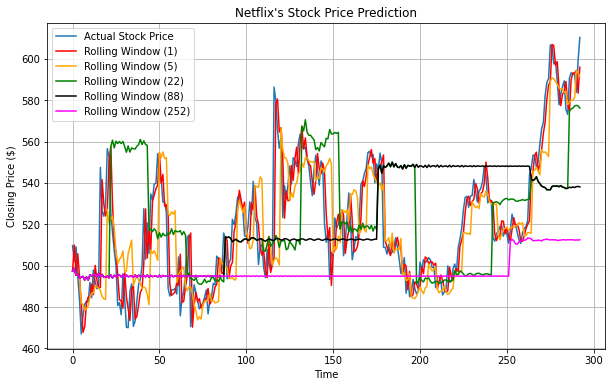

In [38]:
plt.figure()
plt.plot(y_test_copy[:293], label="Actual Stock Price")
plt.plot(forecasts_1[:293], color='red', label="Rolling Window (1)")
plt.plot(forecasts_5[:293], color='orange', label="Rolling Window (5)")
plt.plot(forecasts_22[:293], color='green', label="Rolling Window (22)")
plt.plot(forecasts_88[:293], color='black', label="Rolling Window (88)")
plt.plot(forecasts_252[:293], color='magenta', label="Rolling Window (252)")
plt.title("Netflix's Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()

For this method, we predicted w points at a time, given the best ARIMA values found above. The following iteration, we add the true value to the ARIMA model and we predict another w points. This process repeats until we get to the end of the TS (rolling window). In the following table, we have the results obtained.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-7btt">Points Predicted</th>
    <th class="tg-7btt">MSE Value</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">1</td>
    <td class="tg-c3ow">145.449</td>
  </tr>
  <tr>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">358.871</td>
  </tr>
  <tr>
    <td class="tg-c3ow">22</td>
    <td class="tg-c3ow">1114.158</td>
  </tr>
  <tr>
    <td class="tg-baqh">88</td>
    <td class="tg-baqh">1072.905</td>
  </tr>
  <tr>
    <td class="tg-baqh">252</td>
    <td class="tg-baqh">1326.063</td>
  </tr>
</tbody>
</table>

Generally, we can see a up-trend (the bigger the number of points predicted, the higher the MSE value). In reality, this method cannot be used to forecast, since it needs to real values, that we do not have.

## Holt's ES (Double Exponential Smoothing)

In [39]:
%%time

des_aic = None
des_bic = None
des_sse = None

if os.path.isfile("tests\\des_aic.csv") and os.path.isfile("tests\\des_bic.csv") and os.path.isfile("tests\\des_sse.csv"):
    des_aic = pd.read_csv("tests\\des_aic.csv")
    des_bic = pd.read_csv("tests\\des_bic.csv")
    des_sse = pd.read_csv("tests\\des_sse.csv")
else:
    des_aic = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    des_bic = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    des_sse = pd.DataFrame(columns=["method", "alpha", "beta", "value"])
    
    im = ['estimated', 'heuristic', 'legacy-heuristic']
    alphas = np.arange(0.1, 1, 0.01)
    betas = np.arange(0.1, 1, 0.01)
    
    for i in im:
        for a in alphas:
            for b in betas:
                model = Holt(y_train, initialization_method=i)
                fitted = model.fit(smoothing_level=a, smoothing_trend=b)
                
                # fcast = fitted.forecast(len(y_test))
        
                '''plt.figure()
                plt.plot(y_test, c='blue', label='True values')
                plt.plot(fcast, c='red', label='Prediction')
                plt.show()'''

                des_aic = des_aic.append({"method": i, "alpha": a, "beta": b, "value": fitted.aic}, ignore_index=True)
                des_bic = des_bic.append({"method": i, "alpha": a, "beta": b, "value": fitted.bic}, ignore_index=True)
                des_sse = des_sse.append({"method": i, "alpha": a, "beta": b, "value": fitted.sse}, ignore_index=True)
                
                print(f'method={i}, alpha={a}, beta={b} / AIC: {fitted.aic}')
                print(f'method={i}, alpha={a}, beta={b} / BIC: {fitted.bic}')
                print(f'method={i}, alpha={a}, beta={b} / SSE: {fitted.sse}')
                print("--------------------------------------------")
    des_aic.to_csv("tests\\des_aic.csv", index=False)
    des_bic.to_csv("tests\\des_bic.csv", index=False)
    des_sse.to_csv("tests\\des_sse.csv", index=False)
            

Wall time: 112 ms


Best parameters AIC: (estimated, 0.89, 0.1)
AIC: 12162.621


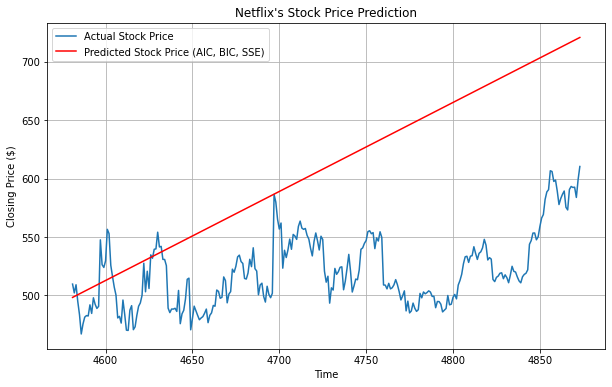

----------------
MSE(y_test, pred): 11009.153


In [40]:
mini_aic = np.min(des_aic["value"])
row_aic = des_aic[des_aic["value"] == mini_aic]
method_aic, alpha_aic, beta_aic = row_aic["method"].values[0], row_aic["alpha"].values[0], row_aic["beta"].values[0]

print(f'Best parameters AIC: ({method_aic}, {round(alpha_aic, 2)}, {beta_aic})\nAIC: {round(mini_aic, 3)}')

model = Holt(y_train, initialization_method=method_aic)
fitted = model.fit(smoothing_level=alpha_aic, smoothing_trend=beta_aic)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, label='Actual Stock Price')
plt.plot(fcast, c='red', label='Predicted Stock Price (AIC, BIC, SSE)')
plt.title("Netflix's Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Closing Price ($)")
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {round(mean_squared_error(y_test, fcast), 3)}")

Best parameters BIC: (estimated, 0.89, 0.1)
BIC: 12188.34


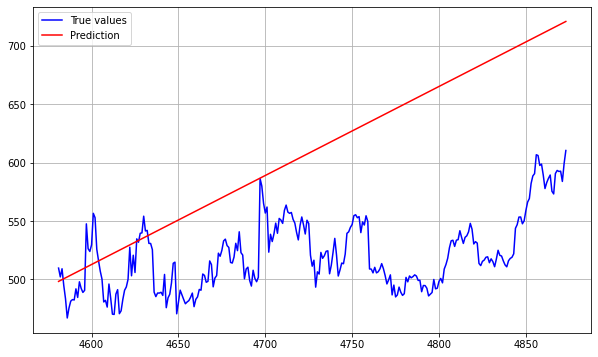

----------------
MSE(y_test, pred): 11009.153


In [41]:
mini_bic = np.min(des_bic["value"])
row_bic = des_bic[des_bic["value"] == mini_bic]
method_bic, alpha_bic, beta_bic = row_bic["method"].values[0], row_bic["alpha"].values[0], row_bic["beta"].values[0]

print(f'Best parameters BIC: ({method_bic}, {round(alpha_bic, 2)}, {beta_bic})\nBIC: {round(mini_bic, 3)}')

model = Holt(y_train, initialization_method=method_bic)
fitted = model.fit(smoothing_level=alpha_bic, smoothing_trend=beta_bic)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, c='blue', label='True values')
plt.plot(fcast, c='red', label='Prediction')
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {round(mean_squared_error(y_test, fcast), 3)}")

Best parameters SSE: (estimated, 0.89, 0.1)
SSE: 65051.902


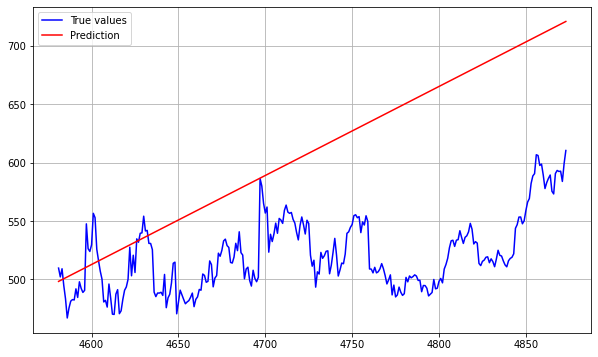

----------------
MSE(y_test, pred): 11009.153


In [42]:
mini_sse = np.min(des_sse["value"])
row_sse = des_sse[des_sse["value"] == mini_sse]
method_sse, alpha_sse, beta_sse = row_sse["method"].values[0], row_sse["alpha"].values[0], row_sse["beta"].values[0]

print(f'Best parameters SSE: ({method_sse}, {round(alpha_sse, 2)}, {beta_sse})\nSSE: {round(mini_sse, 3)}')

model = Holt(y_train, initialization_method=method_sse)
fitted = model.fit(smoothing_level=alpha_sse, smoothing_trend=beta_sse)  # 0.2 / 0.42

fcast = fitted.forecast(len(y_test))

plt.figure()
plt.plot(y_test, c='blue', label='True values')
plt.plot(fcast, c='red', label='Prediction')
plt.legend()
plt.show()

print(f"----------------\nMSE(y_test, pred): {round(mean_squared_error(y_test, fcast), 3)}")

Regarding the DES tests to find the best parameters, we tested alpha (smoothing level for the SES) and beta (smoothing level for the trend) parameters from 0.1 to 0.99 with 0.01 step. We also tested using 3 different metric to evaluate the results on the training set. The best values are presented below:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-baqh"></th>
    <th class="tg-amwm">Best Parameters</th>
    <th class="tg-amwm">Metric Value in Train</th>
    <th class="tg-amwm">Metric Value in Test (MSE)</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-amwm">AIC</td>
    <td class="tg-baqh">(0.89, 0.1)</td>
    <td class="tg-baqh">12162.621</td>
    <td class="tg-baqh">11009.153</td>
  </tr>
  <tr>
    <td class="tg-amwm">BIC</td>
    <td class="tg-baqh">(0.89, 0.1)</td>
    <td class="tg-baqh">12188.340</td>
    <td class="tg-baqh">11009.153</td>
  </tr>
  <tr>
    <td class="tg-amwm">SSE</td>
    <td class="tg-baqh">(0.89, 0.1)</td>
    <td class="tg-baqh">65051.902</td>
    <td class="tg-baqh">11009.153</td>
  </tr>
</tbody>
</table>

Although we cannot compare the results in the training set, we can compare it in the the testing set. All the metrics obtained the same best parameters, and their best MSE value in the testing set is 11009.153. To notice that in the plots, we can see that every prediction was bad.